In [1]:
import numpy as np
import cvxpy as cp

def quadratic_programming(P, q, G, h, A, b, rho, max_iter):
    # ADMM for quadratic programming
    # minimize (1/2)x'Px + q'x, subject to Gx <= h, Ax = b

    n = P.shape[0]
    m_eq = A.shape[0]
    m_ineq = G.shape[0]

    # Initialize variables
    x = cp.Variable(n)
    lambda_ = cp.Variable(m_ineq)
    nu = cp.Variable(m_eq)

    # ADMM iterations
    for _ in range(max_iter):
        # x-update
        objective = cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x +
                                rho/2 * (cp.sum_squares(G @ x - h + lambda_) +
                                         cp.sum_squares(A @ x - b + nu)))
        constraints = [G @ x <= h, A @ x == b]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # lambda-update
        lambda_.value = np.maximum(G @ x.value - h + lambda_.value / rho, 0)

        # nu-update
        nu.value = nu.value + A @ x.value - b

    # Compute objective value
    obj = (1/2) * x.value.T @ P @ x.value + q.T @ x.value
    return x.value, obj

# Define problem data
P = np.array([[4, 1], [1, 2]])
q = np.array([1, 1])
G = np.array([[-1, 0], [0, -1]])
h = np.array([0, 0])
A = np.array([[1, 1]])
b = np.array([1])

# Set ADMM parameters
rho = 1
max_iter = 100

# Call the ADMM function
x, obj = quadratic_programming(P, q, G, h, A, b, rho, max_iter)

# Display results
print('Optimal solution:')
print(x)
print('Objective value:')
print(obj)

Optimal solution:
[0.25 0.75]
Objective value:
1.8749999999999996


In [2]:
import numpy as np

def basis_pursuit(A, b, rho, alpha):
    # Solve basis pursuit via ADMM
    # Returns z and history
    
    # Global constants and defaults
    QUIET = False
    MAX_ITER = 1000
    ABSTOL = 1e-4
    RELTOL = 1e-2
    
    # Data preprocessing
    m, n = A.shape
    
    # ADMM solver
    x = np.zeros((n, 1))
    z = np.zeros((n, 1))
    u = np.zeros((n, 1))
    
    if not QUIET:
        print('{:3s}\t{:10s}\t{:10s}\t{:10s}\t{:10s}\t{:10s}'.format(
            'iter', 'r norm', 'eps pri', 's norm', 'eps dual', 'objective'))
    
    # Precompute static variables for x-update (projection onto Ax=b)
    AAt = A @ A.T
    P = np.eye(n) - A.T @ np.linalg.solve(AAt, A)
    q = A.T @ np.linalg.solve(AAt, b)
    
    # Initialize history dictionary
    history = {
        'objval': [],
        'r_norm': [],
        'eps_pri': [],
        's_norm': [],
        'eps_dual': []
    }
    
    for k in range(MAX_ITER):
        # x-update
        x = P @ (z - u) + q
        
        # z-update with relaxation
        zold = z
        x_hat = alpha * x + (1 - alpha) * zold
        z = shrinkage(x_hat + u, 1 / rho)
        
        u = u + (x_hat - z)
        
        # Diagnostics, reporting, termination checks
        history['objval'].append(objective(A, b, x))
        history['r_norm'].append(np.linalg.norm(x - z))
        history['s_norm'].append(np.linalg.norm(-rho * (z - zold)))
        
        n_sqrt = np.sqrt(n)
        history['eps_pri'].append(n_sqrt * ABSTOL + RELTOL * max(np.linalg.norm(x), np.linalg.norm(-z)))
        history['eps_dual'].append(n_sqrt * ABSTOL + RELTOL * np.linalg.norm(rho * u))
        
        if not QUIET:
            print('{:3d}\t{:10.4f}\t{:10.4f}\t{:10.4f}\t{:10.4f}\t{:10.2f}'.format(
                k+1, history['r_norm'][-1], history['eps_pri'][-1],
                history['s_norm'][-1], history['eps_dual'][-1], history['objval'][-1]))
        
        if (history['r_norm'][-1] < history['eps_pri'][-1] and
                history['s_norm'][-1] < history['eps_dual'][-1]):
            break
    
    return z, history

def objective(A, b, x):
    # Compute objective value
    return np.linalg.norm(x, 1)

def shrinkage(a, kappa):
    # Shrinkage operator
    return np.maximum(0, a - kappa) - np.maximum(0, -a - kappa)


iter	r norm    	eps pri   	s norm    	eps dual  	objective 
  1	    1.1602	    0.0121	    0.0000	    0.0121	      4.84
  2	    1.1169	    0.0121	    0.0987	    0.0233	      4.84
  3	    0.8167	    0.0122	    0.6864	    0.0303	      4.68
  4	    0.5009	    0.0152	    0.6637	    0.0322	      4.65
  5	    0.5240	    0.0168	    0.2462	    0.0333	      5.05
  6	    0.4605	    0.0160	    0.1474	    0.0354	      4.67
  7	    0.4010	    0.0150	    0.1881	    0.0378	      4.47
  8	    0.3196	    0.0146	    0.2305	    0.0398	      4.39
  9	    0.2724	    0.0145	    0.2282	    0.0410	      4.45
 10	    0.2496	    0.0145	    0.1931	    0.0419	      4.51
 11	    0.2359	    0.0143	    0.1645	    0.0425	      4.44
 12	    0.2090	    0.0140	    0.1444	    0.0429	      4.44
 13	    0.1439	    0.0136	    0.1812	    0.0430	      4.41
 14	    0.0887	    0.0133	    0.1627	    0.0430	      4.26
 15	    0.0907	    0.0134	    0.1275	    0.0428	      4.27
 16	    0.0774	    0.0136	    0.1128	    0.0427	      4

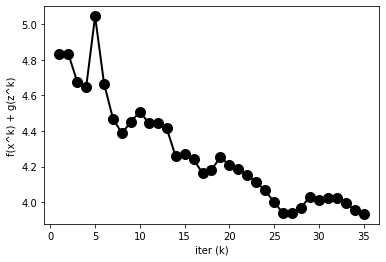

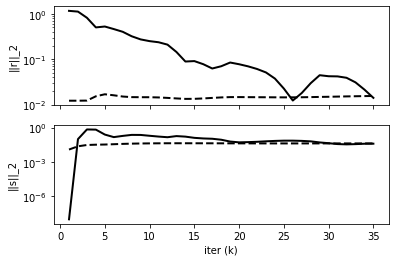

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate problem data
np.random.seed(0)
n = 30
m = 10
A = np.random.randn(m, n)

x = np.random.randn(n, 1)
x = np.multiply(x, np.random.rand(n, 1))
b = A @ x

# Solve problem
x, history = basis_pursuit(A, b, 1.0, 1.0)
K = len(history['objval'])

# Plot objective value
fig1 = plt.figure()
plt.plot(range(1, K+1), history['objval'], 'k', marker='o', markersize=10, linewidth=2)
plt.ylabel('f(x^k) + g(z^k)')
plt.xlabel('iter (k)')

# Plot residual norms
fig2, axs = plt.subplots(2, 1, sharex=True)
axs[0].semilogy(range(1, K+1), np.maximum(1e-8, history['r_norm']), 'k',
                range(1, K+1), history['eps_pri'], 'k--', linewidth=2)
axs[0].set_ylabel('||r||_2')

axs[1].semilogy(range(1, K+1), np.maximum(1e-8, history['s_norm']), 'k',
                range(1, K+1), history['eps_dual'], 'k--', linewidth=2)
axs[1].set_ylabel('||s||_2')
axs[1].set_xlabel('iter (k)')

plt.show()
